In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
attempts = pd.read_csv("data/attempts.csv")
students = pd.read_csv("data/student_data.csv")

#### Para los cálculos con tiempo, primero debemos "corregir" data. En particular reemplazaremos durationseconds a 300, para todos los registros mayores a 300 (asumimos que el tiempo máximo es 5 minutos y si hay tiempos mayores lo más probable es que el estudiante no estaba concentrado en la actividad). Esta cota fue elegida mirando el histograma de tiempos. Cuantos casos hay con mas de 300 segundos en una actividad?


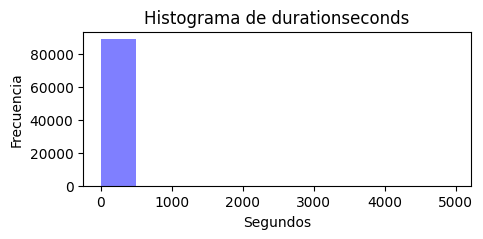

In [4]:
# Crea el histograma
plt.figure(figsize=(5, 2))
plt.hist(attempts.durationseconds, bins=10, color='blue', alpha=0.5) 
plt.title('Histograma de durationseconds') 
plt.xlabel('Segundos') 
plt.ylabel('Frecuencia')
plt.show()

### Generar DataFrame _"engagement with practice"_ 

Se refiere a la cantidad de actividad que el estudiante realizó en problemas y ejemplos del sistema. Se pueden definir varias variables en torno al tiempo empleado y al número de actividades, en general, o en distinto tipos de material (problemas, ejemplos, etc). 

Definiremos por cada estudiante las siguientes 'features':

- **total_time** : suma de durationseconds para todos los registros del usuario
- **total_activity** : contar todas las filas en attempts por cada estudiante (toda la actividad distintos tipos de ejercicios)
- **qp_time** : suma de durationseconds solo de actividad de QUIZPET y PARSONS
- **wa_time** : suma de durationseconds solo de actividad de WEBEX y ANIMATED_EXAMPLES
- **qp_activity** : contar actividad en QUIZPET y PARSONS 
- **wa_activity** : contar actividad en WEBEX y ANIMATED_EXAMPLES
- **total_time_be** : suma de durationseconds para todos los registros del usuario antes del examen (before exam). Esto es la actividad antes del relativetime=5600000
- **total_activity_be** : contar todas las filas en attempts por cada estudiante antes del relativetime=5600000

In [5]:
# Aplicar la transformación a 300 en los valores superiores a 300
attempts['durationseconds'] = np.clip(attempts['durationseconds'], None, 300)

In [6]:
# Crear DataFrame practice con las columnas requeridas
practice = pd.DataFrame(columns=['student','total_time', 'total_activity', 'qp_time', 'wa_time', 'qp_activity', 'wa_activity', 'total_time_be', 'total_activity_be'])
practice['student'] = students['student'].unique()

# Obtener el DataFrame before_exam
before_exam = attempts.loc[attempts['relativetime'] <= 5600000]

# Definir las funciones de agregación
def get_totaltime(name):
    return attempts.loc[attempts['student'] == name, 'durationseconds'].sum()

def get_totalactivity(name):
    return attempts.loc[attempts['student'] == name].shape[0]

def get_qptime(name):
    return attempts.query("student == @name and applabel in ['QUIZPET', 'PARSONS']")['durationseconds'].sum()

def get_watime(name):
    return attempts.query("student == @name and applabel in ['WEBEX', 'ANIMATED_EXAMPLE']")['durationseconds'].sum()

def get_qpactivity(name):
    return attempts.query("student == @name and applabel in ['QUIZPET', 'PARSONS']").shape[0]

def get_waactivity(name):
    return attempts.query("student == @name and applabel in ['WEBEX', 'ANIMATED_EXAMPLE']").shape[0]

def get_totaltime_be(name, before_exam):
    return before_exam.loc[before_exam['student'] == name, 'durationseconds'].sum()

def get_totalactivity_be(name, before_exam):
    return before_exam.loc[before_exam['student'] == name].shape[0]

# Utilizar apply con lambda para aplicar las funciones de agregación a lo largo de las filas del DataFrame practice
# y asignar los resultados a las columnas correspondientes
practice['total_time'] = practice['student'].apply(get_totaltime)
practice['total_activity'] = practice['student'].apply(get_totalactivity)
practice['qp_time'] = practice['student'].apply(get_qptime)
practice['wa_time'] = practice['student'].apply(get_watime)
practice['qp_activity'] = practice['student'].apply(get_qpactivity)
practice['wa_activity'] = practice['student'].apply(get_waactivity)
practice['total_time_be'] = practice['student'].apply(get_totaltime_be, before_exam=before_exam)
practice['total_activity_be'] = practice['student'].apply(get_totalactivity_be, before_exam=before_exam)

### Generar DataFrame "Learning" 

Se entiende como lo aprendido entre el inicio y el fin de semestre. Para esto usaremos pretest, posttest y exam. Exam está en otra escala así que es necesario transformarlo. 

Las features:

- **pretest** tal como está ya en la data
- **posttest** tal como está ya en la data
- **exam_norm**: exam normalizado al rango 0..1 (exam está en el rango 0..100)
- **lgain_pp**: normalized learning gain entre pre y posttest que se calcula: (post-pre)/(1-pre)
- **lgain_pe**: normalized learning gain entre pretest y exam_norm que se calcula: (exam_norm-pre)/(1-pre)

In [7]:
# Crear DataFrame learning con columnas definidas
learning = pd.DataFrame(columns=['student', 'pretest', 'posttest', 'exam_norm', 'lgain_pp', 'lgain_pe'])

# Asignar valores a las columnas del DataFrame
learning.student = students.student.unique()
learning.pretest = students.pretest
learning.posttest = students.posttest
learning.exam_norm = students.exam

# Replace empty strings with NaN values
learning.replace(' ', np.nan, inplace=True)

# Convert specific columns to integer data type
learning[['pretest', 'posttest', 'exam_norm', 'lgain_pp', 'lgain_pe']] = learning[['pretest', 'posttest', 'exam_norm', 'lgain_pp', 'lgain_pe']]

# Convertir columna exam_norm a tipo numérico, ignorando errores y convirtiendo a NaN
learning['exam_norm'] = pd.to_numeric(learning['exam_norm'], errors='coerce')
learning['posttest'] = pd.to_numeric(learning['posttest'], errors='coerce')
learning['pretest'] = pd.to_numeric(learning['pretest'], errors='coerce')

# Normalizar valores de la columna exam_norm
learning['exam_norm'] = learning['exam_norm'] / 100

# Crear máscara booleana para identificar valores negativos en la columna exam_norm
mask = learning['exam_norm'] < 0

# Reemplazar valores negativos por 0 en la columna exam_norm
learning['exam_norm'] = np.where(mask, 0, learning['exam_norm'])

# Reemplazar celdas vacías por NaN
learning['pretest'].replace('', np.nan, inplace=True)

# Rellenar las celdas vacías (NaN) con el valor 0
learning.fillna(0, inplace=True)

# Generar valores de columna lgain_pp 
learning['lgain_pp'] = (learning['posttest'] - learning['pretest']) / (1 - learning['pretest'])

# Generar valores de columna lgain_pe
learning['lgain_pe'] = (learning['exam_norm'] - learning['pretest']) / (1 - learning['pretest'])

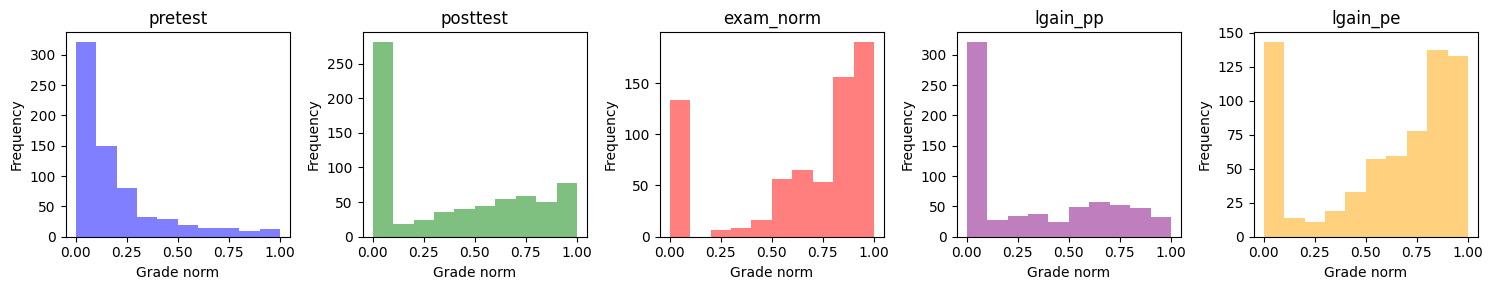

In [8]:
# Create a copy of the DataFrame to avoid modifying the original data
learning_copy = learning.copy()

# Aplicar umbralización para transformar los valores negativos en cero utilizando el accesor 'loc'
learning_copy.loc[learning_copy['lgain_pp'] < 0, 'lgain_pp'] = 0
learning_copy.loc[learning_copy['lgain_pe'] < 0, 'lgain_pe'] = 0

# Crear el subplot con 5 histogramas
fig, axs = plt.subplots(1, 5, figsize=(15, 3), tight_layout=True)

axs[0].hist(learning_copy['pretest'], bins=10, color='blue', alpha=0.5)
axs[0].set_title('pretest')
axs[0].set_xlabel('Grade norm')
axs[0].set_ylabel('Frequency')

axs[1].hist(learning_copy['posttest'], bins=10, color='green', alpha=0.5)
axs[1].set_title('posttest')
axs[1].set_xlabel('Grade norm')
axs[1].set_ylabel('Frequency')

axs[2].hist(learning_copy['exam_norm'], bins=10, color='red', alpha=0.5)
axs[2].set_title('exam_norm')
axs[2].set_xlabel('Grade norm')
axs[2].set_ylabel('Frequency')

axs[3].hist(learning_copy['lgain_pp'], bins=10, color='purple', alpha=0.5)
axs[3].set_title('lgain_pp')
axs[3].set_xlabel('Grade norm')
axs[3].set_ylabel('Frequency')

axs[4].hist(learning_copy['lgain_pe'], bins=10, color='orange', alpha=0.5)
axs[4].set_title('lgain_pe')
axs[4].set_xlabel('Grade norm')
axs[4].set_ylabel('Frequency')

# Mostrar el plot
plt.show()

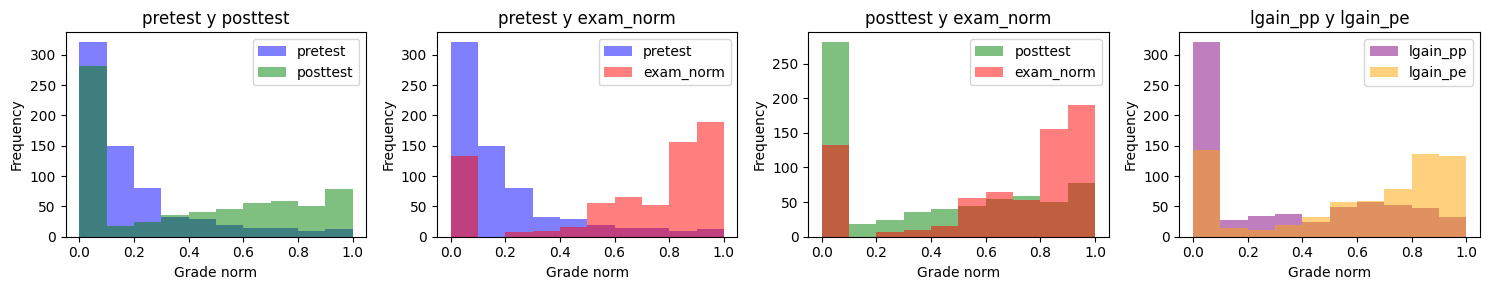

In [9]:
# Crear el subplot con 1 fila y 1 columna
fig, ax = plt.subplots(1, 4, figsize=(15,3), tight_layout=True)

# Generar el histograma para pretest, posttest y exam_norm
ax[0].hist(learning_copy['pretest'], bins=10, color='blue', alpha=0.5, label='pretest', linewidth=1)
ax[0].hist(learning_copy['posttest'], bins=10, color='green', alpha=0.5, label='posttest', linewidth=1)
ax[0].set_title('pretest y posttest')
ax[0].set_xlabel('Grade norm')
ax[0].set_ylabel('Frequency')
ax[0].legend()

# Generar el histograma para pretest, y exam_norm
ax[1].hist(learning_copy['pretest'], bins=10, color='blue', alpha=0.5, label='pretest', linewidth=1)
ax[1].hist(learning_copy['exam_norm'], bins=10, color='red', alpha=0.5, label='exam_norm', linewidth=1)
ax[1].set_title('pretest y exam_norm')
ax[1].set_xlabel('Grade norm')
ax[1].set_ylabel('Frequency')
ax[1].legend()

# Generar el histograma para pretest, y exam_norm
ax[2].hist(learning_copy['posttest'], bins=10, color='green', alpha=0.5, label='posttest', linewidth=1)
ax[2].hist(learning_copy['exam_norm'], bins=10, color='red', alpha=0.5, label='exam_norm', linewidth=1)
ax[2].set_title('posttest y exam_norm')
ax[2].set_xlabel('Grade norm')
ax[2].set_ylabel('Frequency')
ax[2].legend()

# Generar el histograma para lgain_pp y lgain_pe
ax[3].hist(learning_copy['lgain_pp'], bins=10, color='purple', alpha=0.5, label='lgain_pp', linewidth=1)
ax[3].hist(learning_copy['lgain_pe'], bins=10, color='orange', alpha=0.5, label='lgain_pe', linewidth=1)
ax[3].set_title('lgain_pp y lgain_pe')
ax[3].set_xlabel('Grade norm')
ax[3].set_ylabel('Frequency')
ax[3].legend()

# Mostrar el plot
plt.show()

### Concatenar todos los DataFrames

Generar un archivo data_prep.csv con las columnas student,social,gender,take_exam,Fi,CBi,Vi,MAPi,PApi,[todas las features listadas arriba]

In [10]:
# Eliminar la columna 'student' de los dataframes practice y learning
practice.drop('student', axis=1, inplace=True)
learning.drop('student', axis=1, inplace=True)

# Concatenar los tres dataframes sin la columna 'student'
merged_df = pd.concat([students[['student', 'social', 'gender', 'take_exam', 'Fi', 'CBi', 'Vi', 'MApi', 'PApi']], 
                       practice, learning], axis=1)

In [11]:
# Despliega todas las filas y columnas
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Ordena DataFrame por student
df = merged_df.sort_values('student')

# Guardar el DataFrame en un archivo CSV
#df.to_csv('data/data_prep.csv', index=False)

df

,student,social,gender,take_exam,Fi,CBi,Vi,MApi,PApi,total_time,total_activity,qp_time,wa_time,qp_activity,wa_activity,total_time_be,total_activity_be,pretest,posttest,exam_norm,lgain_pp,lgain_pe
57,user0003,0,1,0,0.5,0.4,0.87,0.33,0,37,1,37,0,1,0,37,1,0.27,0.00,0.00,-0.369863,-0.369863
47,user0004,0,1,1,0.42,0.4,0.47,0.44,0.67,837,35,549,288,11,24,161,13,0.00,0.73,0.90,0.730000,0.900000
43,user0005,0,1,1,0.75,0.8,1,0.89,0.33,35,4,19,16,1,3,35,4,0.64,1.00,0.90,1.000000,0.722222
4,user0006,0,1,1,0.58,0.05,0.8,0.67,0.56,0,0,0,0,0,0,0,0,0.09,0.00,0.71,-0.098901,0.681319
31,user0007,0,1,1,0.58,0.15,0.67,0.67,0.67,0,0,0,0,0,0,0,0,0.09,1.00,0.81,1.000000,0.791209
71,user0008,0,1,1,0.67,0.7,0.67,0.89,0.33,12859,830,7540,5319,106,724,4857,334,0.45,0.64,1.00,0.345455,1.000000
72,user0009,0,1,1,0.58,0.65,0.8,0.78,0,3874,731,2646,1228,99,632,952,93,0.09,0.00,0.88,-0.098901,0.868132
78,user0010,0,1,1,0.83,0.85,0.67,0.83,0.89,1793,110,821,972,23,87,1793,110,0.18,0.00,0.85,-0.219512,0.817073
65,user0011,0,1,1,0.58,0.45,0.67,0.61,0.22,3201,263,1377,1824,27,236,3201,263,0.27,0.82,0.87,0.753425,0.821918
32,user0012,0,1,1,0.42,0.3,0.4,0.67,0.67,0,0,0,0,0,0,0,0,0.18,0.36,0.33,0.219512,0.182927


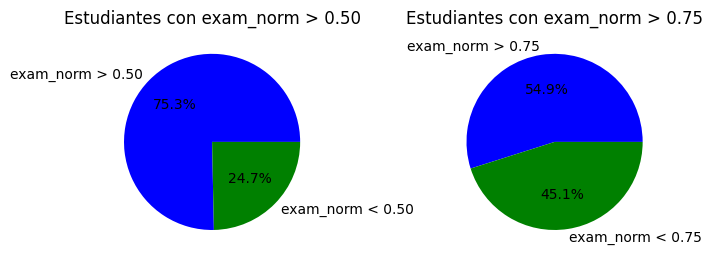

In [12]:
# Filtrar estudiantes con exam_norm > 0.50
students_50 = df[df['exam_norm'] > 0.50]['exam_norm'].count()

# Filtrar estudiantes con exam_norm > 0.75
students_75 = df[df['exam_norm'] > 0.75]['exam_norm'].count()

# Etiquetas para los gráficos de tarta
labels = ['exam_norm > 0.50', 'exam_norm < 0.50']
labels2 = ['exam_norm > 0.75', 'exam_norm < 0.75']

# Valores para los gráficos de tarta
values = [students_50, len(df)-students_50]
values2 = [students_75, len(df)-students_75]

# Crear subplots con 1 fila y 2 columnas
fig, axes = plt.subplots(1, 2, figsize=(7, 3))

# Colores para los gráficos de tarta
colors = ['blue', 'green']

# Graficar el primer gráfico de tarta en el primer subplot
axes[0].pie(values, labels=labels, colors=colors, autopct='%1.1f%%')
axes[0].set_title('Estudiantes con exam_norm > 0.50')

# Graficar el segundo gráfico de tarta en el segundo subplot
axes[1].pie(values2, labels=labels2, colors=colors, autopct='%1.1f%%')
axes[1].set_title('Estudiantes con exam_norm > 0.75')

# Ajustar diseño de subplots
plt.tight_layout()

# Mostrar los gráficos
plt.show()